In [35]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from brukeropusreader import read_file
import numpy as np
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
import umap
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore')  # Ignore all warnings

In [18]:

# Chemins vers vos dossiers
folder_path_oe = 'OE tissue'
folder_path_re = 'RE tissue'
folder_path_trachea = 'Trachea tissue'

In [19]:
# Fonction pour lister les fichiers dans un dossier
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# Lister les fichiers dans chaque dossier
files_re = list_files(folder_path_re)
files_oe = list_files(folder_path_oe)
files_trachea = list_files(folder_path_trachea)

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)

print("\nOE Folder:")
print(f"Number of files: {len(files_oe)}")
print("Files:", files_oe)

print("\nTrachea Folder:")
print(f"Number of files: {len(files_trachea)}")
print("Files:", files_trachea)

RE Folder:
Number of files: 159
Files: ['19022024 RE 5.0000', '20240318 RE B2.0000', '20240318 RE B3.0003', '20240415 C2 RE.0003', '20240311 RE 3.0003', '20240311 RE 2.0003', '20240304 RE 4.0004', '20240408 C2 RE.0004', '20240318 RE B5.0000', '19022024 RE 1.0000', '19022024 RE 4.0000', '20240304 RE 3.0004', '20240311 RE 1.0005', '20240311 RE 5.0001', '19022024 RE 2.0000', '20240318 RE B3.0004', '20240311 RE 1.0008', '20240408 C4 RE.0003', '20240415 C4 RE.0003', '20240415 C1 RE.0000', '19022024 RE 4.0001', '20240318 RE B2.0001', '19022024 RE 3.0004', '20240304 RE 2.0004', '19022024 RE 1.0003', '20240304 RE 1.0003', '20240311 RE 3.0002', '19022024 RE 2.0004', '20240311 RE 5.0003', '20240311 RE 4.0004', '19022024 RE 4.0003', '20240415 C3 RE.0001', '20240408 C3 RE.0002', '20240304 RE 3.0000', '20240408 C5 RE.0001', '20240415 C3 RE.0000', '20240311 RE 1.0006', '20240415 C1 RE.0002', '20240408 C2 RE.0000', '20240311 RE 1.0001', '20240318 RE B4.0004', '20240311 RE 1.0007', '20240318 RE B1.000

In [20]:
# Définir l'ensemble commun de nombres d'onde
start_wavenumber = 5000  # Le nombre d'onde de départ
end_wavenumber = 400  # Le nombre d'onde de fin
resolution = 1  # La résolution en cm⁻¹

# Générer l'ensemble commun de nombres d'onde
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Vérifiez la première et dernière valeurs ainsi que la taille de l'ensemble pour s'assurer qu'il correspond à vos attentes
print("Premier nombre d'onde :", common_wavenumbers[0])
print("Dernier nombre d'onde :", common_wavenumbers[-1])
print("Nombre total de points :", len(common_wavenumbers))

Premier nombre d'onde : 5000
Dernier nombre d'onde : 400
Nombre total de points : 4601


In [21]:
def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    # Supposons que les nombres d'onde sont stockés dans une clé 'WN' dans les données retournées
    # Extraire le nombre de points, le nombre d'onde de début et de fin
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
# Générer la liste des nombres d'onde
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    
    return wavenumbers

In [22]:
def get_spectral_data(file_path):
    """
    Extracts spectral data (e.g., absorbance values) from a file.

    Parameters:
    - file_path: The path to the Bruker file.

    Returns:
    - A numpy array containing the spectral data.
    """
    opus_data = read_file(file_path)
    # Assuming the spectral data is stored in the 'AB' key
    spectral_data = opus_data['AB']
    return spectral_data

# You may need to adjust the `read_file` function to return the entire opus_data dictionary.


In [23]:
def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    """
    Interpolates the spectral data from a file to a common set of wavenumbers.
    
    Parameters:
    - file_path: The path to the file.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of the interpolated spectral data.
    """
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

In [24]:
def z_score_normalize(data):
    """
    Normalizes a data array using Z-score normalization.
    
    Parameters:
    - data: A numpy array of spectral data.
    
    Returns:
    - The Z-score normalized spectral data.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

In [25]:
def process_directory(folder_path, common_wavenumbers):
    """
    Processes all files in a directory, interpolating and normalizing their spectral data.
    
    Parameters:
    - folder_path: The path to the directory.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of all the normalized spectral data from the directory.
    """
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

In [26]:
# Process directories
data_oe = process_directory('OE tissue', common_wavenumbers)
data_re = process_directory('RE tissue', common_wavenumbers)
data_trachea = process_directory('Trachea tissue', common_wavenumbers)

In [27]:
print(data_oe)

[[-0.82329514 -1.03620166 -0.91845662 ...  0.0634433   0.20625885
   0.19267305]
 [-0.66599232 -0.90158994 -0.88844313 ...  0.17364294  0.48562095
  -0.13049977]
 [-0.55731009 -0.75168351 -0.99050443 ...  0.25779538  0.26138407
   0.50113961]
 ...
 [-0.66380361 -0.89185486 -0.90663467 ...  0.44515549  0.31741038
  -0.25770352]
 [-0.97341109 -0.91401882 -0.9615577  ...  0.48653366  0.24188255
   0.36834625]
 [-0.7340351  -0.77134432 -0.84544008 ...  0.20214604  0.62021413
  -0.22689326]]


In [28]:
# Vérifier si la liste des fichiers n'est pas vide
if files_trachea:
    first_file_trachea = files_trachea[0]
    print("Le premier fichier dans le dossier 'Trachea tissue' est:", first_file_trachea)
else:
    print("Aucun fichier trouvé dans le dossier.")

Le premier fichier dans le dossier 'Trachea tissue' est: 20240311 TE 5.0004


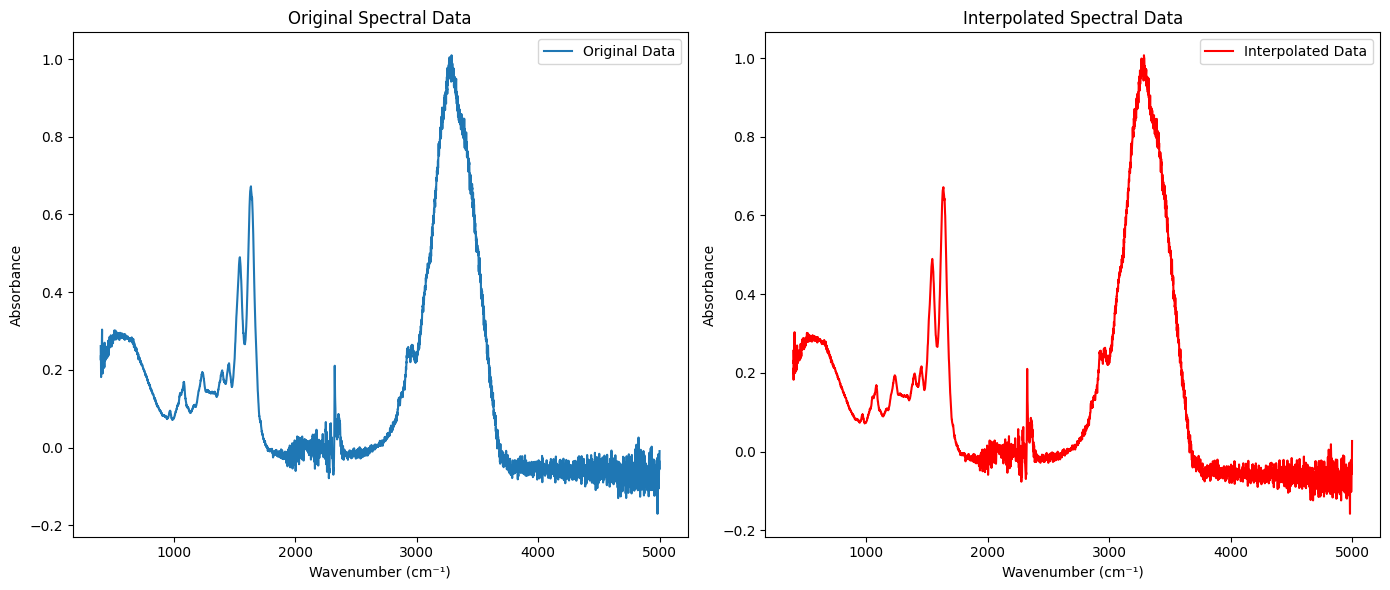

In [29]:
def plot_original_vs_interpolated(file_path, common_wavenumbers):
    # Obtenir les données spectrales et les nombres d'onde originaux
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    
    # Interpolation des données aux nombres d'onde communs
    interpolated_data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)

    # Tracer les données originales
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1ère subplot
    plt.plot(original_wavenumbers, original_data, label='Original Data')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title('Original Spectral Data')
    plt.legend()

    # Tracer les données interpolées
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème subplot
    plt.plot(common_wavenumbers, interpolated_data, label='Interpolated Data', color='red')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title('Interpolated Spectral Data')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation sur un fichier spécifique
# Chemin complet du premier fichier
first_file_path = os.path.join(folder_path_trachea, first_file_trachea)

# Utilisation du fichier pour tracer les données originales et interpolées
plot_original_vs_interpolated(first_file_path, common_wavenumbers)

In [30]:
def print_wavenumber_range(file_path, common_wavenumbers):
    # Extraire les nombres d'onde originaux
    original_wavenumbers = get_wavenumbers(file_path)
    
    # Afficher la plage des nombres d'onde originaux
    print("Plage des nombres d'onde originaux:")
    print(" - Min:", np.min(original_wavenumbers))
    print(" - Max:", np.max(original_wavenumbers))
    
    # Afficher la plage des nombres d'onde interpolés
    print("Plage des nombres d'onde interpolés:")
    print(" - Min:", np.min(common_wavenumbers))
    print(" - Max:", np.max(common_wavenumbers))

# Utilisation du premier fichier du dossier "Trachea tissue"
folder_path_trachea = 'Trachea tissue'
files_trachea = list_files(folder_path_trachea)

if files_trachea:
    first_file_trachea = files_trachea[0]
    first_file_path = os.path.join(folder_path_trachea, first_file_trachea)
    print_wavenumber_range(first_file_path, common_wavenumbers)
else:
    print("Aucun fichier trouvé dans le dossier.")

Plage des nombres d'onde originaux:
 - Min: 399.9009272456169
 - Max: 4999.296694397926
Plage des nombres d'onde interpolés:
 - Min: 400
 - Max: 5000


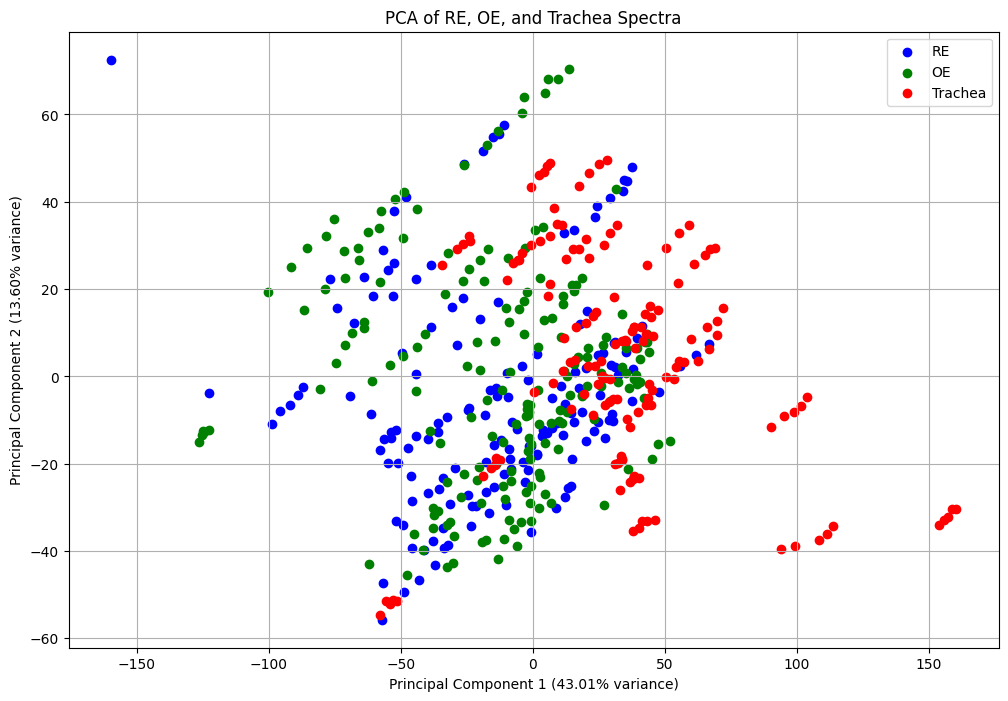

In [32]:
# Combine data and labels
X = np.vstack((data_oe, data_re, data_trachea))
y = np.concatenate((labels_oe, labels_re, labels_trachea))

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

# Determine the correct indices for each group
re_end = len(data_re)
oe_end = re_end + len(data_oe)

# Plot the PCA results with correct indices for each group
plt.figure(figsize=(12, 8))
plt.scatter(principal_components[:re_end, 0], principal_components[:re_end, 1], c='blue', label='RE')
plt.scatter(principal_components[re_end:oe_end, 0], principal_components[re_end:oe_end, 1], c='green', label='OE')
plt.scatter(principal_components[oe_end:, 0], principal_components[oe_end:, 1], c='red', label='Trachea')

plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% variance)')
plt.title('PCA of RE, OE, and Trachea Spectra')
plt.legend()
plt.grid(True)
plt.show()

2024-05-27 11:11:34.009900: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 11:11:34.490404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 11:11:34.490446: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 11:11:34.490477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 11:11:34.511320: I tensorflow/core/platform/cpu_feature_g

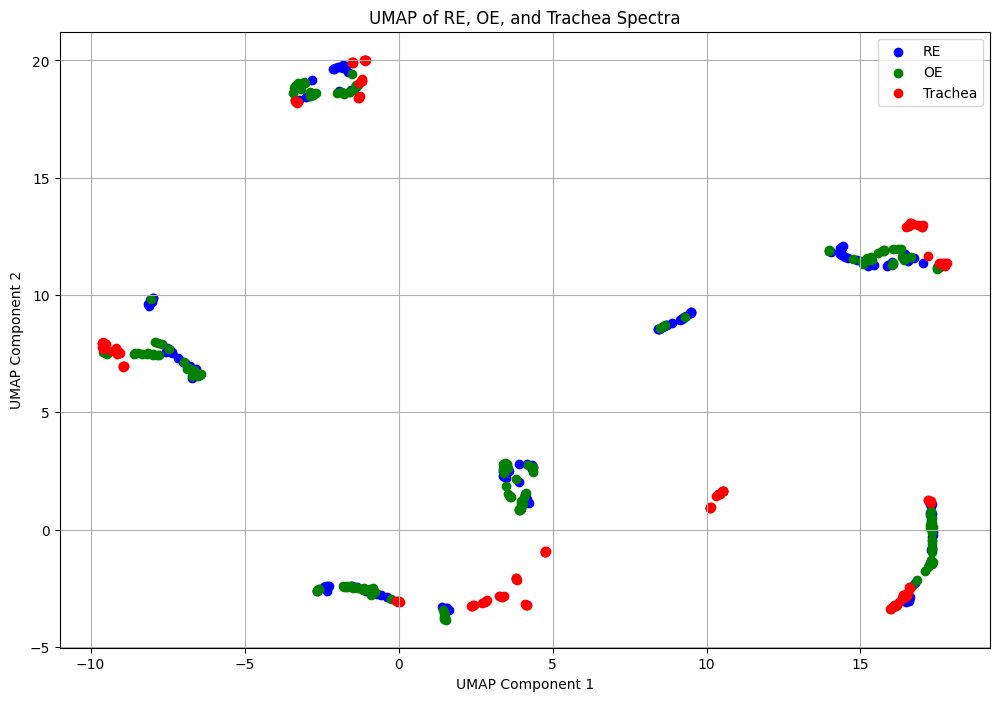

In [34]:
# Apply UMAP
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_components = umap_model.fit_transform(X_scaled)

# Plot the UMAP results with correct indices for each group
plt.figure(figsize=(12, 8))
plt.scatter(umap_components[:re_end, 0], umap_components[:re_end, 1], c='blue', label='RE')
plt.scatter(umap_components[re_end:oe_end, 0], umap_components[re_end:oe_end, 1], c='green', label='OE')
plt.scatter(umap_components[oe_end:, 0], umap_components[oe_end:, 1], c='red', label='Trachea')

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of RE, OE, and Trachea Spectra')
plt.legend()
plt.grid(True)
plt.show()

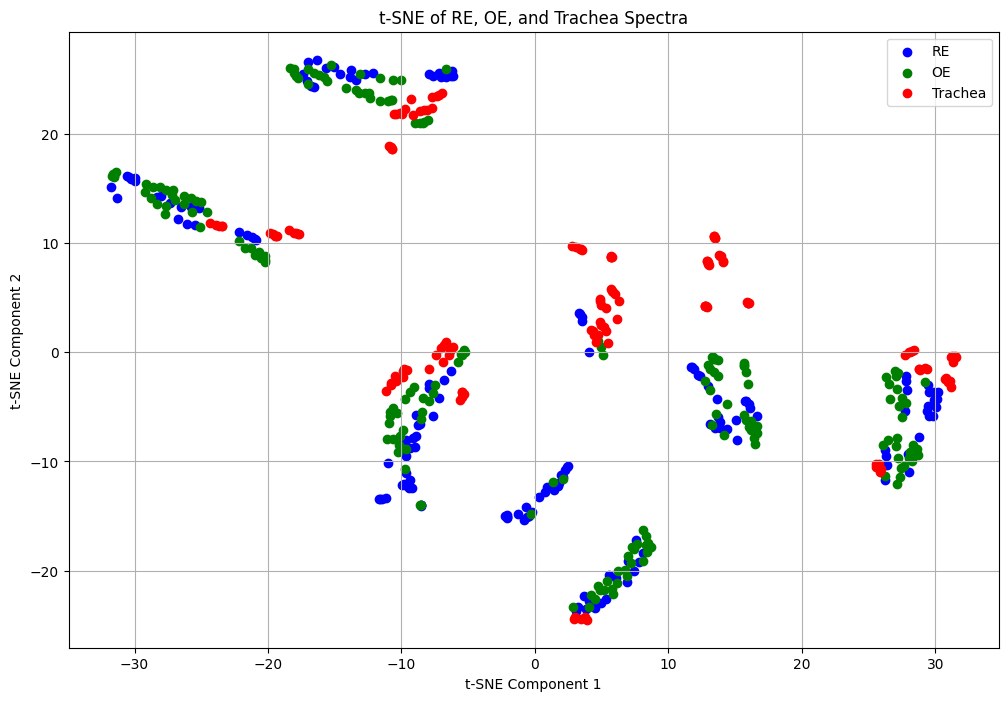

In [36]:
# Apply t-SNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_components = tsne_model.fit_transform(X_scaled)

# Plot the t-SNE results with correct indices for each group
plt.figure(figsize=(12, 8))
plt.scatter(tsne_components[:re_end, 0], tsne_components[:re_end, 1], c='blue', label='RE')
plt.scatter(tsne_components[re_end:oe_end, 0], tsne_components[re_end:oe_end, 1], c='green', label='OE')
plt.scatter(tsne_components[oe_end:, 0], tsne_components[oe_end:, 1], c='red', label='Trachea')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of RE, OE, and Trachea Spectra')
plt.legend()
plt.grid(True)
plt.show()